In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

In [65]:
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

In [66]:
# 1) Configuration — set your CSV path here
file_path = r"Match Winner.csv"  # <<< CHANGE THIS
RANDOM_STATE = 42
CV_FOLDS = 5
SAVE_MODEL = True
SAVE_DIR = "./models"

# 2) Load dataset (safe-check)
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV file not found. Update file_path to the correct location: {file_path}")

df = pd.read_csv(file_path)
print("Loaded dataset shape:", df.shape)
display(df.head(5))


Loaded dataset shape: (6840, 40)


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,0,19/08/00,Charlton,Man City,4,0,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2,19/08/00,Coventry,Middlesbrough,1,3,NH,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,3,19/08/00,Derby,Southampton,2,2,NH,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,4,19/08/00,Leeds,Everton,2,0,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


In [67]:
# -------------------------
# 2) Quick checks & cleaning
# -------------------------
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows present?:", df.duplicated().any())
if df.duplicated().any():
    print("Dropping duplicate rows...")
    df = df.drop_duplicates().reset_index(drop=True)
    print("New shape:", df.shape)

# If there are rows with missing important fields, drop them (or you can impute)
df = df.dropna(subset=['FTR', 'HTGS', 'ATGS', 'HTP', 'ATP'], how='any').reset_index(drop=True)
print("After dropping rows with crucial NA -> shape:", df.shape)


Missing values per column:
 Unnamed: 0       0
Date             0
HomeTeam         0
AwayTeam         0
FTHG             0
FTAG             0
FTR              0
HTGS             0
ATGS             0
HTGC             0
ATGC             0
HTP              0
ATP              0
HM1              0
HM2              0
HM3              0
HM4              0
HM5              0
AM1              0
AM2              0
AM3              0
AM4              0
AM5              0
MW               0
HTFormPtsStr     0
ATFormPtsStr     0
HTFormPts        0
ATFormPts        0
HTWinStreak3     0
HTWinStreak5     0
HTLossStreak3    0
HTLossStreak5    0
ATWinStreak3     0
ATWinStreak5     0
ATLossStreak3    0
ATLossStreak5    0
HTGD             0
ATGD             0
DiffPts          0
DiffFormPts      0
dtype: int64

Duplicate rows present?: False
After dropping rows with crucial NA -> shape: (6840, 40)



Target (FTR) value counts:
FTR
NH    3664
H     3176
Name: count, dtype: int64


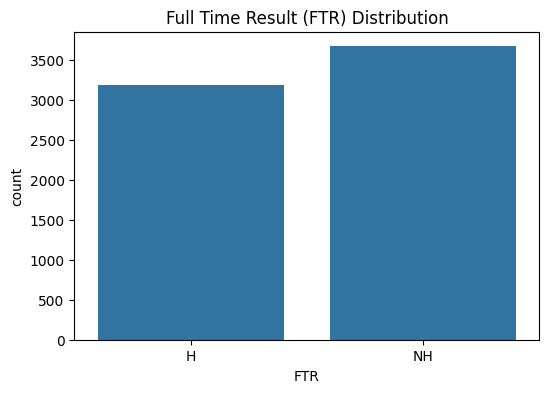

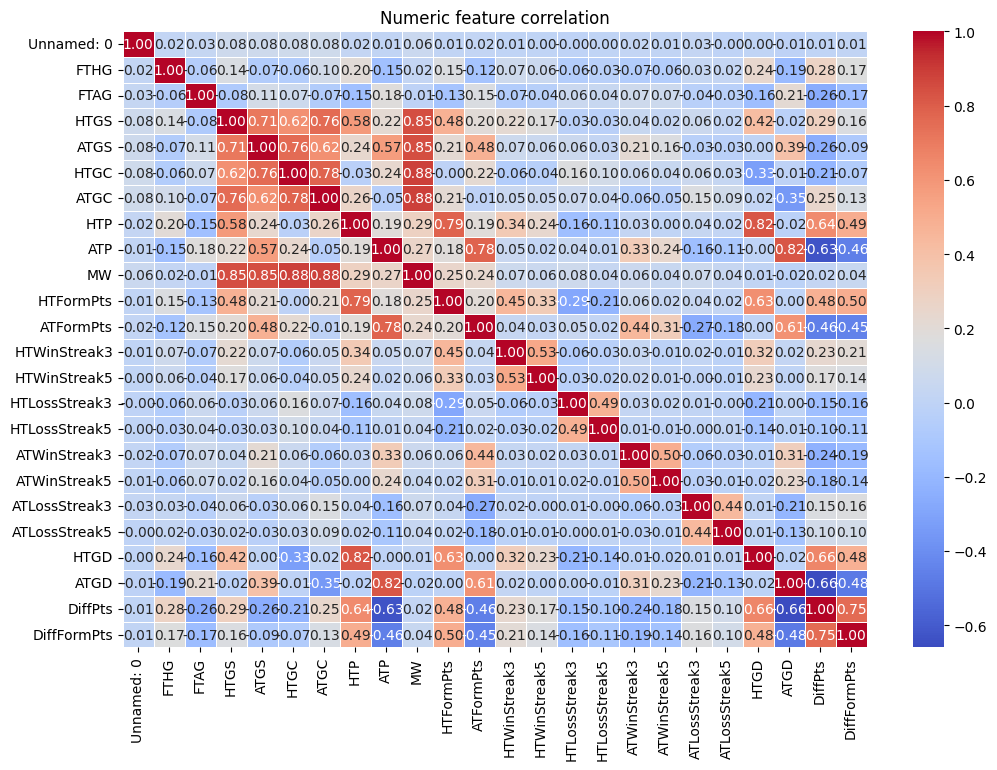

In [68]:
print("\nTarget (FTR) value counts:")
print(df['FTR'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='FTR', data=df)
plt.title('Full Time Result (FTR) Distribution')
plt.show()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 1:
    plt.figure(figsize=(12,8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
    plt.title('Numeric feature correlation')
    plt.show()


In [69]:
# -------------------------
# 4) Feature engineering
# -------------------------
# Example: goal differences, total goals, home_advantage flags etc.
df['home_goal_diff'] = df['HTGS'] - df['ATGS']   # home team's goals - away team's goals for that match
df['total_goals'] = df['HTGS'] + df['ATGS']
# If you have home/away points columns (HTP/ATP) keep them; else drop if missing
print("\nAdded features: 'home_goal_diff', 'total_goals'")

# If there are columns for recent form (HTFormPts/ATFormPts etc.), keep them. If not, skip.
possible_form_cols = [c for c in df.columns if 'Form' in c or 'form' in c or 'WinStreak' in c]
print("Form-like columns detected:", possible_form_cols)


Added features: 'home_goal_diff', 'total_goals'
Form-like columns detected: ['HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'ATWinStreak3', 'ATWinStreak5', 'DiffFormPts']


In [70]:
# -------------------------
# 5) Select features and target
# -------------------------
# Choose a set of features that are generally useful. Adjust to your dataset columns.
features = []
# Prefer numeric match-level stats
for col in ['HTGS','ATGS','HTGC','ATGC','HTP','ATP','home_goal_diff','total_goals']:
    if col in df.columns:
        features.append(col)

# include form columns if present
features += [c for c in possible_form_cols if c in df.columns]

print("\nUsing features:", features)

# Target encoding: FTR -> H/D/A
le_ftr = LabelEncoder()
df['FTR_encoded'] = le_ftr.fit_transform(df['FTR'])
print("FTR mapping:", dict(zip(le_ftr.classes_, le_ftr.transform(le_ftr.classes_))))

X = df[features].copy()
y = df['FTR_encoded'].copy()



Using features: ['HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'home_goal_diff', 'total_goals', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'ATWinStreak3', 'ATWinStreak5', 'DiffFormPts']
FTR mapping: {'H': np.int64(0), 'NH': np.int64(1)}


In [71]:

# -------------------------
# 6) Train-test split (stratify to preserve class proportions)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTrain/test shapes:", X_train.shape, X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())


Train/test shapes: (5472, 17) (1368, 17)
y_train distribution:
 FTR_encoded
1    2931
0    2541
Name: count, dtype: int64
y_test distribution:
 FTR_encoded
1    733
0    635
Name: count, dtype: int64


In [72]:
# -------------------------
# Full preprocessing: Scaling + Encoding
# -------------------------
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Example: Load your dataset
# df = pd.read_csv("your_file.csv")

# Split features and target
TARGET = "MW"  # Replace with your target column
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: scale numeric, encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Fit and transform training data, transform test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)


Processed X_train shape: (5472, 2511)
Processed X_test shape: (1368, 2511)


In [86]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=400, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Train
    model.fit(X_train_scaled, y_train_simple)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Accuracy
    acc = accuracy_score(y_test_simple, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    
    # Classification Report
    print("\nClassification Report (H=Home, NH=Not Home):")
    print(classification_report(y_test_simple, y_pred, zero_division=0, digits=2))



--- Training Logistic Regression ---


Logistic Regression Accuracy: 0.4737

Classification Report (H=Home, NH=Not Home):
              precision    recall  f1-score   support

           H       0.03      0.49      0.05        39
          NH       0.97      0.47      0.64      1329

    accuracy                           0.47      1368
   macro avg       0.50      0.48      0.34      1368
weighted avg       0.94      0.47      0.62      1368


--- Training Random Forest ---
Random Forest Accuracy: 0.9700

Classification Report (H=Home, NH=Not Home):
              precision    recall  f1-score   support

           H       0.00      0.00      0.00        39
          NH       0.97      1.00      0.98      1329

    accuracy                           0.97      1368
   macro avg       0.49      0.50      0.49      1368
weighted avg       0.94      0.97      0.96      1368




Best model: LogisticRegression with accuracy 0.6564327485380117


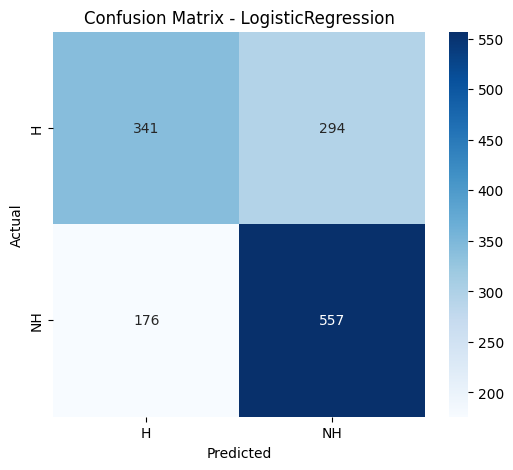

In [ ]:
# -------------------------
# 9) Confusion matrix for best model
# -------------------------
best_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_name]['model']
best_pred = results[best_name]['y_pred']
print("\nBest model:", best_name, "with accuracy", results[best_name]['accuracy'])

plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_ftr.classes_, yticklabels=le_ftr.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}')
plt.show()

In [88]:
# -------------------------
# 10) Feature importance (for tree-based models)
# -------------------------
if hasattr(best_model, "feature_importances_"):
    fi = best_model.feature_importances_
    fi_df = pd.DataFrame({'feature': features, 'importance': fi}).sort_values('importance', ascending=False)
    print("\nFeature importances:\n", fi_df)
    plt.figure(figsize=(8,5))
    sns.barplot(x='importance', y='feature', data=fi_df)
    plt.title(f'Feature importances - {best_name}')
    plt.show()


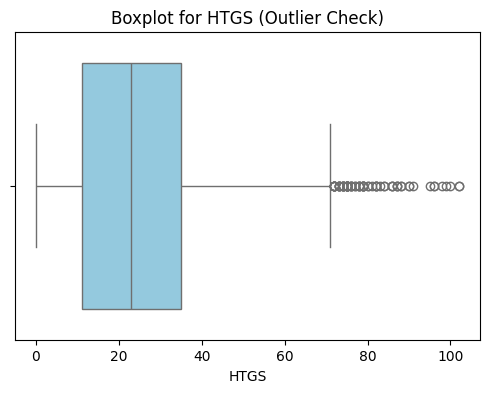

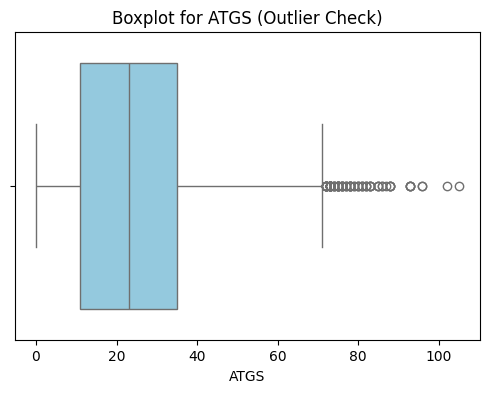

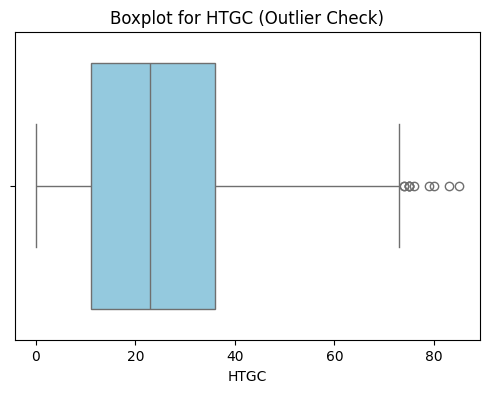

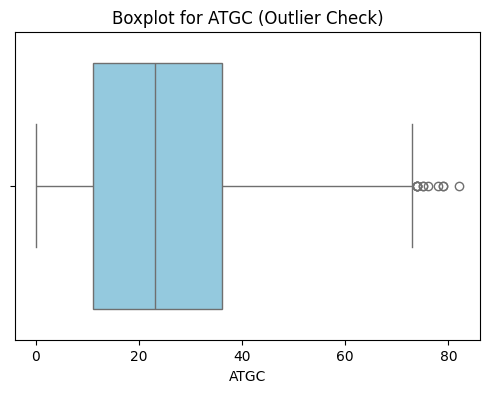

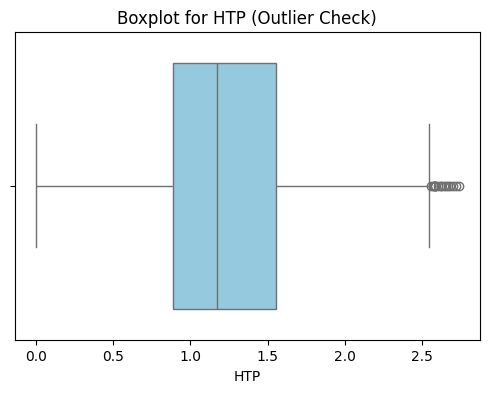

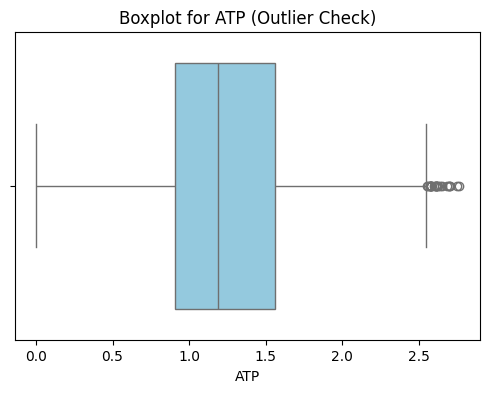

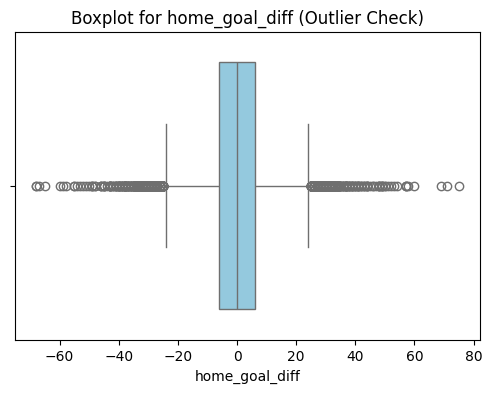

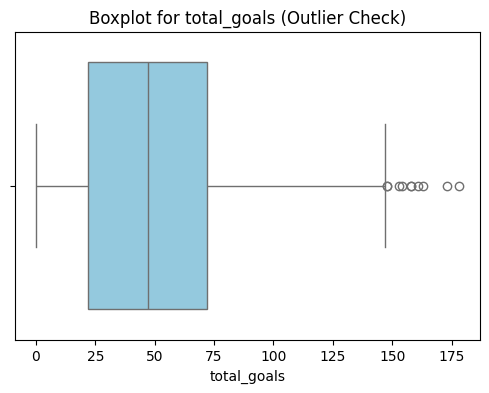

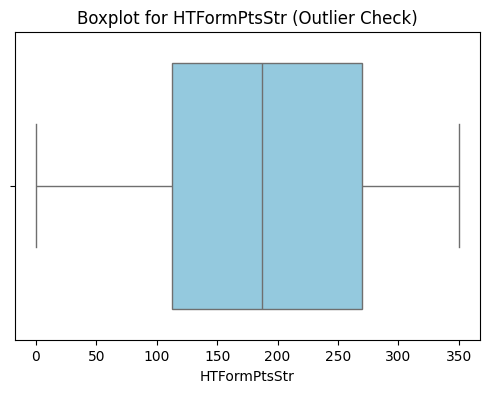

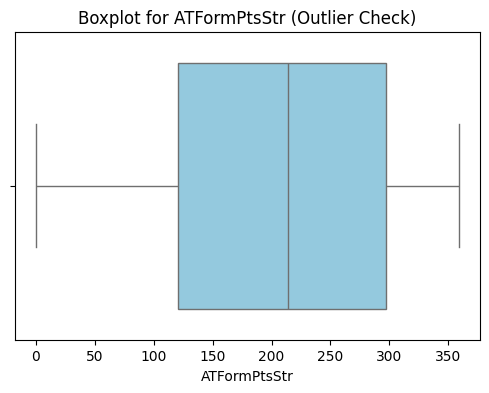

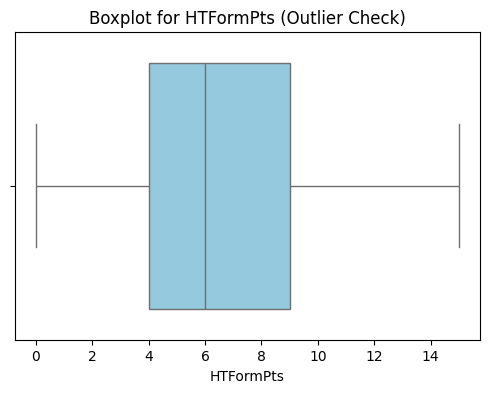

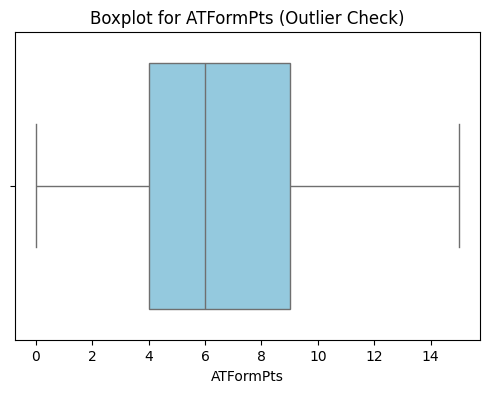

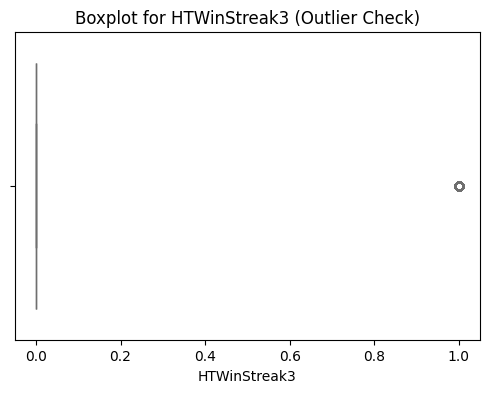

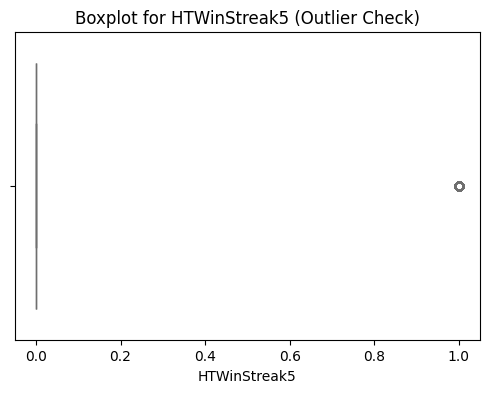

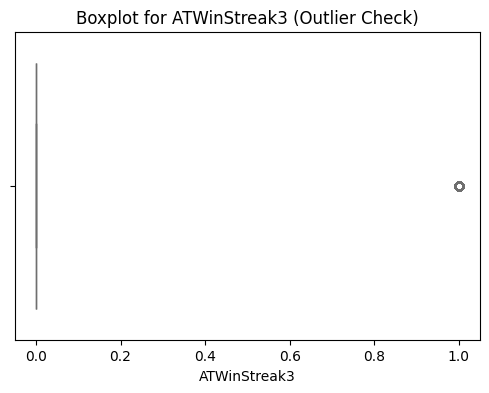

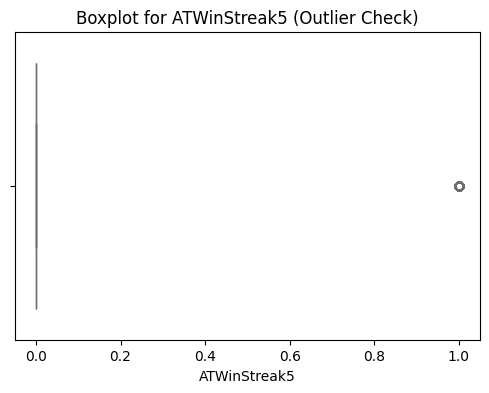

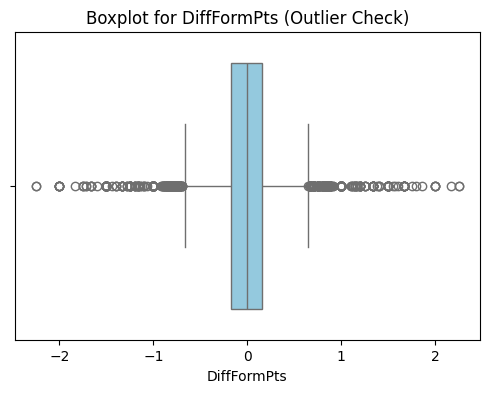

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


numeric_cols = X_encoded.select_dtypes(include=['int64', 'float64']).columns


for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=X_encoded[col], color='skyblue')
    plt.title(f"Boxplot for {col} (Outlier Check)")
    plt.xlabel(col)
    plt.show()


In [ ]:

# -------------------------
# 12) Save best model + scaler
# -------------------------
MODEL_OUT = "best_match_model.pkl"
SCALER_OUT = "scaler.pkl"
joblib.dump(best_model, MODEL_OUT)
joblib.dump(scaler, SCALER_OUT)
print(f"\nSaved best model to {MODEL_OUT} and scaler to {SCALER_OUT}")


Saved best model to best_match_model.pkl and scaler to scaler.pkl
